# Store Demand Forecasting

**Importing Libraries**

In [1]:
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns 
import lightgbm as lgb
from lightgbm import early_stopping, log_evaluation

**You are given 5 years of store-item sales data 50 different items at 10 different stores.**

In [2]:
df = pd.read_csv("data/train.csv", parse_dates=['date'])

**Exploratory Data Analysis**

In [3]:
df.sample(5)

date  store  item  sales
247523 2015-10-11      6    14     47
227887 2017-01-03      5    13     40
120923 2014-02-12      7     7     27
581499 2015-04-12      9    32     50
358871 2015-09-03      7    20     38

In [4]:
df.shape

(913000, 4)

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 913000 entries, 0 to 912999
Data columns (total 4 columns):
 #   Column  Non-Null Count   Dtype         
---  ------  --------------   -----         
 0   date    913000 non-null  datetime64[ns]
 1   store   913000 non-null  int64         
 2   item    913000 non-null  int64         
 3   sales   913000 non-null  int64         
dtypes: datetime64[ns](1), int64(3)
memory usage: 27.9 MB


In [6]:
df.describe([0.10, 0.30, 0.50, 0.70, 0.90])

date          store           item  \
count                         913000  913000.000000  913000.000000   
mean   2015-07-02 11:59:59.999999744       5.500000      25.500000   
min              2013-01-01 00:00:00       1.000000       1.000000   
10%              2013-07-02 00:00:00       1.900000       5.900000   
30%              2014-07-02 00:00:00       3.700000      15.700000   
50%              2015-07-02 12:00:00       5.500000      25.500000   
70%              2016-07-02 00:00:00       7.300000      35.300000   
90%              2017-07-02 00:00:00       9.100000      45.100000   
max              2017-12-31 00:00:00      10.000000      50.000000   
std                              NaN       2.872283      14.430878   

               sales  
count  913000.000000  
mean       52.250287  
min         0.000000  
10%        20.000000  
30%        33.000000  
50%        47.000000  
70%        64.000000  
90%        93.000000  
max       231.000000  
std        28.801144

In [7]:
print("Beginning date:",df['date'].min())
print("Ending date:",df['date'].max())

Beginning date: 2013-01-01 00:00:00
Ending date: 2017-12-31 00:00:00


In [8]:
print("Number of unique stores:", df['store'].nunique())
print("Number of unique items:", df['item'].nunique())

Number of unique stores: 10
Number of unique items: 50


In [9]:
print("Number of unique items in each store:", df.groupby(["store"])["item"].nunique())

Number of unique items in each store: store
1     50
2     50
3     50
4     50
5     50
6     50
7     50
8     50
9     50
10    50
Name: item, dtype: int64


In [10]:
df['month'] = df.date.dt.month

In [11]:
df.sample()

date  store  item  sales  month
821383 2017-02-18     10    45     84      2

In [12]:
monthly_sales = df.groupby(['month'])['sales'].sum().reset_index()

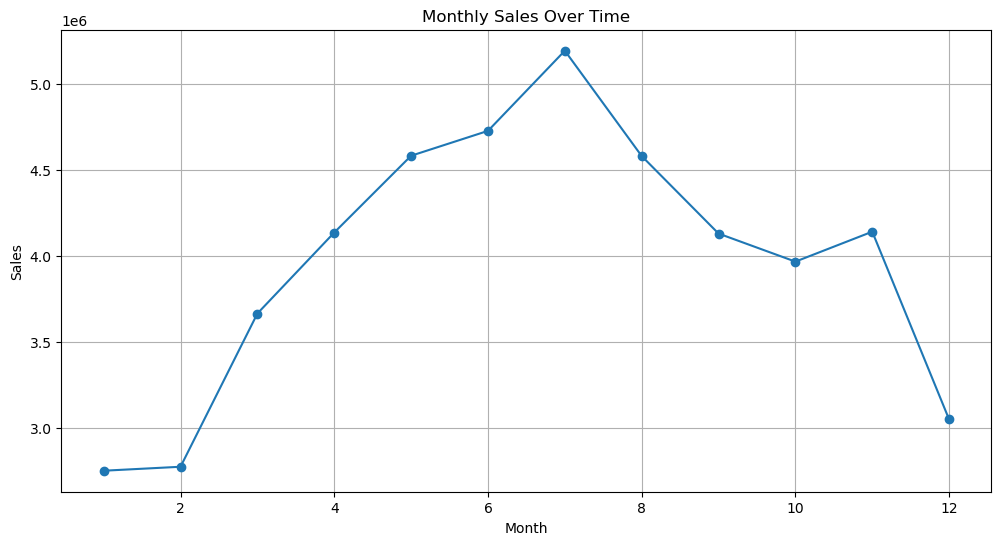

In [13]:
plt.figure(figsize=(12,6))
plt.plot(monthly_sales['month'], monthly_sales['sales'], marker= 'o')
plt.title("Monthly Sales Over Time")
plt.xlabel("Month")
plt.ylabel("Sales")
plt.grid(True)
plt.show()

In [14]:
monthly_sales_store = df.groupby(['month', 'store'])['sales'].sum().reset_index()
monthly_sales_store.sample()

month  store   sales
32      4      3  472478

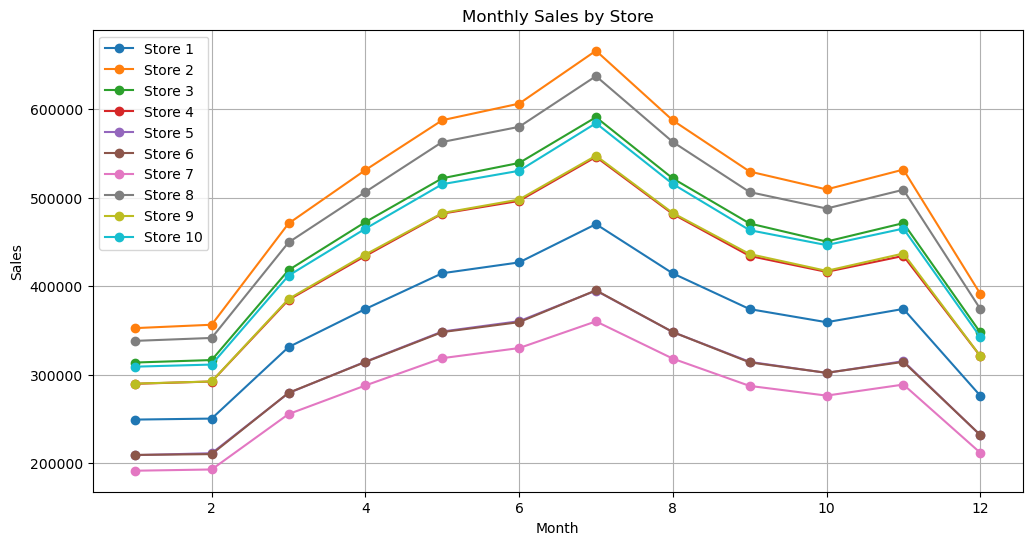

In [15]:
plt.figure(figsize=(12,6))
for store_id, group in monthly_sales_store.groupby('store'):
    plt.plot(group['month'], group['sales'], marker='o', label=f'Store {store_id}')
plt.title("Monthly Sales by Store")
plt.xlabel("Month")
plt.ylabel("Sales")
plt.legend()
plt.grid(True)
plt.show()

**Random Noise**

In [16]:
def random_noise(dataframe):
    return np.random.normal(scale=1.6, size=(len(dataframe)))

In [17]:
df.sort_values(by=['store', 'item', 'date'], axis=0, inplace=True)
df.head()

date  store  item  sales  month
0 2013-01-01      1     1     13      1
1 2013-01-02      1     1     11      1
2 2013-01-03      1     1     14      1
3 2013-01-04      1     1     13      1
4 2013-01-05      1     1     10      1

**Shifted Features**

In [18]:
def lag_features(dataframe, lags):
    for lag in lags:
        dataframe['sales_lag_' + str(lag)] = dataframe.groupby(["store", "item"])['sales'].transform(
            lambda x: x.shift(lag)) + random_noise(dataframe)
    return dataframe

df = lag_features(df, [91, 98, 105, 112, 119, 126, 182, 364, 546, 728])

In [19]:
df.sample(5)

date  store  item  sales  month  sales_lag_91  sales_lag_98  \
618039 2015-05-02      9    34     43      5     18.360475     14.909761   
151847 2013-10-17      4     9     51     10     55.169820     59.975443   
596422 2016-02-21      7    33     51      2     70.083163     69.013070   
376395 2013-08-28      7    21     26      8     23.031748     18.677216   
550135 2014-05-25      2    31    116      5     68.622031     68.489394   

        sales_lag_105  sales_lag_112  sales_lag_119  sales_lag_126  \
618039      23.294575      18.241129      16.855250      19.704491   
151847      59.424018      56.784157      55.540198      52.304541   
596422      53.930695      54.886411      44.862507      54.253212   
376395      22.350758      19.692578      25.230658      29.404774   
550135      77.405380      59.876323      51.007435      56.197334   

        sales_lag_182  sales_lag_364  sales_lag_546  sales_lag_728  
618039      26.700367      22.666400      37.987357      29.171748  
151847      38.746381            NaN            NaN            NaN  
596422      77.978448      59.841249      63.286049      45.890149  
376395      21.397375            NaN            NaN            NaN  
550135      76.462088      76.219555            NaN            NaN

**Rolling Mean Features**

In [20]:
def roll_mean_features(dataframe, windows):
    for window in windows:
        dataframe['sales_roll_mean_' + str(window)] = dataframe.groupby(["store", "item"])['sales'].\
                                        transform(
            lambda x: x.shift(1).rolling(window=window, min_periods=10, win_type="triang").mean()) + random_noise(dataframe)
    return dataframe

df = roll_mean_features(df, [365, 546, 730])

In [21]:
df.sample(5)

date  store  item  sales  month  sales_lag_91  sales_lag_98  \
341167 2017-03-12      7    19     31      3     33.161989     20.591098   
311921 2017-02-10      1    18     75      2     79.102702     83.789453   
600949 2013-07-15     10    33     61      7     59.646694     42.569644   
383639 2013-06-29      1    22     74      6     50.768274     58.143330   
689201 2015-03-11      8    38     89      3     54.405953     54.998404   

        sales_lag_105  sales_lag_112  sales_lag_119  sales_lag_126  \
341167      45.058530      42.335977      51.616768      47.656429   
311921      84.937303      67.097252      98.386081      85.031641   
600949      43.772410      57.127004      38.392352      44.679144   
383639      80.411052      65.303224      56.212314      50.539615   
689201     110.935766      95.623735     112.561984      85.368136   

        sales_lag_182  sales_lag_364  sales_lag_546  sales_lag_728  \
341167      37.386326      37.314884      39.280587      33.241940   
311921      79.666415      70.533002      98.606366      72.760959   
600949      33.708360            NaN            NaN            NaN   
383639            NaN            NaN            NaN            NaN   
689201      86.386998      62.810898      91.805983      67.249210   

        sales_roll_mean_365  sales_roll_mean_546  sales_roll_mean_730  
341167            31.408180            30.578799            28.270288  
311921            91.648316            83.341618            81.553003  
600949            56.029160            55.488383            58.378727  
383639            52.940867            51.134385            51.694336  
689201            97.874244            95.754602            91.205747

**Exponentially Weighted Mean Features**

In [22]:
def ewm_features(dataframe, alphas, lags):
    for alpha in alphas:
        for lag in lags:
            dataframe['sales_ewm_features_' + str(alpha).replace(".", "") + "_lag_" + str(lag)] = \
                dataframe.groupby(["store", "item"])['sales'].transform(lambda x: x.shift(lag).ewm(alpha=alpha).mean())
    return dataframe

alphas = [0.99, 0.95, 0.9, 0.8, 0.7, 0.5]
lags = [91, 98, 105, 112, 180, 270, 365, 546, 728]

df = ewm_features(df, alphas, lags)

In [23]:
df.tail()

date  store  item  sales  month  sales_lag_91  sales_lag_98  \
912995 2017-12-27     10    50     63     12     82.538782     72.110738   
912996 2017-12-28     10    50     59     12     82.705825     89.083536   
912997 2017-12-29     10    50     74     12     87.637481     95.089185   
912998 2017-12-30     10    50     62     12    101.286352     93.976237   
912999 2017-12-31     10    50     82     12    100.130716     98.255135   

        sales_lag_105  sales_lag_112  sales_lag_119  ...  \
912995      83.082996      77.974710      77.698582  ...   
912996      89.553350      79.624277      92.016753  ...   
912997      93.864005      98.694816      96.721297  ...   
912998      95.349634      91.838066      91.701128  ...   
912999     107.244540      95.405228     105.503091  ...   

        sales_ewm_features_07_lag_728  sales_ewm_features_05_lag_91  \
912995                      49.410597                     79.657373   
912996                      45.623179                     80.828687   
912997                      54.986954                     85.414343   
912998                      60.596086                     94.207172   
912999                      74.878826                     96.603586   

        sales_ewm_features_05_lag_98  sales_ewm_features_05_lag_105  \
912995                     77.143760                      80.401219   
912996                     83.071880                      85.200610   
912997                     90.035940                      89.600305   
912998                     93.517970                      93.300152   
912999                     96.258985                     100.150076   

        sales_ewm_features_05_lag_112  sales_ewm_features_05_lag_180  \
912995                      79.356088                     109.036310   
912996                      78.678044                     114.018155   
912997                      87.839022                     117.009078   
912998                      90.419511                     108.004539   
912999                      93.209756                     103.002269   

        sales_ewm_features_05_lag_270  sales_ewm_features_05_lag_365  \
912995                      84.929217                      61.127792   
912996                      97.464609                      52.063896   
912997                      80.732304                      60.031948   
912998                      93.366152                      61.515974   
912999                      81.183076                      62.757987   

        sales_ewm_features_05_lag_546  sales_ewm_features_05_lag_728  
912995                      84.107010                      49.495322  
912996                      87.553505                      46.747661  
912997                      94.276753                      52.873830  
912998                     103.638376                      57.936915  
912999                     113.319188                      69.468458  

[5 rows x 72 columns]

In [24]:
df['day_of_week'] = df.date.dt.dayofweek

In [25]:
df.sample()

date  store  item  sales  month  sales_lag_91  sales_lag_98  \
878953 2014-10-10      2    49     29     10     48.023309     40.591851   

        sales_lag_105  sales_lag_112  sales_lag_119  ...  \
878953      39.716309      28.565482      43.145891  ...   

        sales_ewm_features_05_lag_91  sales_ewm_features_05_lag_98  \
878953                     45.779819                     42.816856   

        sales_ewm_features_05_lag_105  sales_ewm_features_05_lag_112  \
878953                      40.557566                      35.368451   

        sales_ewm_features_05_lag_180  sales_ewm_features_05_lag_270  \
878953                      45.149069                      26.498397   

        sales_ewm_features_05_lag_365  sales_ewm_features_05_lag_546  \
878953                      26.587673                      35.407263   

        sales_ewm_features_05_lag_728  day_of_week  
878953                            NaN            4  

[1 rows x 73 columns]

In [26]:
df.shape

(913000, 73)

In [27]:
df = pd.get_dummies(df, columns=['day_of_week', 'month'])

In [28]:
df.shape

(913000, 90)

In [29]:
df.sample()

date  store  item  sales  sales_lag_91  sales_lag_98  \
47381 2017-09-28      6     3     38     25.369758     49.158404   

       sales_lag_105  sales_lag_112  sales_lag_119  sales_lag_126  ...  \
47381      39.149075      38.158924      38.912734      31.617165  ...   

       month_3  month_4  month_5  month_6  month_7  month_8  month_9  \
47381    False    False    False    False    False    False     True   

       month_10  month_11  month_12  
47381     False     False     False  

[1 rows x 90 columns]

In [30]:
df['sales'] = np.log1p(df["sales"].values)

In [31]:
df.sample(5)

date  store  item     sales  sales_lag_91  sales_lag_98  \
865644 2013-05-01      5    48  3.465736     23.342863     13.315910   
375841 2017-02-20      6    21  3.332205     25.136792     23.904875   
724504 2016-11-09      7    40  3.367296     32.604689     22.063218   
910987 2017-06-28      9    50  4.330733     58.567417     70.529037   
35338  2014-10-07     10     2  4.060443     72.975949     77.593057   

        sales_lag_105  sales_lag_112  sales_lag_119  sales_lag_126  ...  \
865644      16.953433      21.438987      22.104692            NaN  ...   
375841      29.210314      17.000428      26.827498      30.727547  ...   
724504      35.623699      18.590824      25.479983      35.585299  ...   
910987      67.826384      70.287580      49.631209      46.587706  ...   
35338       78.416722      63.692120      73.722517      80.809953  ...   

        month_3  month_4  month_5  month_6  month_7  month_8  month_9  \
865644    False    False     True    False    False    False    False   
375841    False    False    False    False    False    False    False   
724504    False    False    False    False    False    False    False   
910987    False    False    False     True    False    False    False   
35338     False    False    False    False    False    False    False   

        month_10  month_11  month_12  
865644     False     False     False  
375841     False     False     False  
724504     False      True     False  
910987     False     False     False  
35338       True     False     False  

[5 rows x 90 columns]

In [32]:
train = df.loc[(df["date"] < "2017-07-01"), :]

val = df.loc[(df["date"] >= "2017-07-01") & (df["date"] < "2018-01-01"), :]

cols = [col for col in train.columns if col not in ['date', 'id', "sales"]]

In [33]:
Y_train = train['sales']

X_train = train[cols]

Y_val = val['sales']

X_val = val[cols]

Y_train.shape, X_train.shape, Y_val.shape, X_val.shape

((821000,), (821000, 88), (92000,), (92000, 88))

In [34]:
def smape(preds, target):
    n = len(preds)
    masked_arr = ~((preds == 0) & (target == 0))
    preds, target = preds[masked_arr], target[masked_arr]
    num = np.abs(preds - target)
    denom = np.abs(preds) + np.abs(target)
    smape_val = (200 * (np.sum(num/denom))) / n
    return smape_val

def lgbm_smape(preds, train_data):
    labels = train_data.get_label()
    smape_val = smape(np.expm1(preds), np.expm1(labels))
    return 'SMAPE', smape_val, False

**LightGBM Model**

In [35]:
lgb_params = {'metric': {'mae'},
              'num_leaves': 10,
              'learning_rate': 0.02,
              'feature_fraction': 0.8,
              'max_depth': 5,
              'verbose': 0,
              'num_boost_round': 2000,
              'early_stopping_rounds': 200,
              'nthread': -1}

In [36]:
lgbtrain = lgb.Dataset(data=X_train, label=Y_train, feature_name=cols)
lgbval = lgb.Dataset(data=X_val, label=Y_val, reference=lgbtrain, feature_name=cols)

model = lgb.train(
    lgb_params,
    lgbtrain,
    valid_sets=[lgbtrain, lgbval],
    num_boost_round=lgb_params['num_boost_round'],
    feval=lgbm_smape,
    callbacks=[
        early_stopping(lgb_params['early_stopping_rounds']), 
        log_evaluation(100) 
    ]
)


y_pred_val = model.predict(X_val, num_iteration=model.best_iteration)

smape(np.expm1(y_pred_val), np.expm1(Y_val))

Training until validation scores don't improve for 200 rounds
[100]	training's l1: 0.173819	training's SMAPE: 17.7196	valid_1's l1: 0.151044	valid_1's SMAPE: 15.3572
[200]	training's l1: 0.143336	training's SMAPE: 14.6738	valid_1's l1: 0.126797	valid_1's SMAPE: 12.9303
[300]	training's l1: 0.136592	training's SMAPE: 13.9975	valid_1's l1: 0.123581	valid_1's SMAPE: 12.608
[400]	training's l1: 0.134218	training's SMAPE: 13.7596	valid_1's l1: 0.122173	valid_1's SMAPE: 12.4667
[500]	training's l1: 0.13289	training's SMAPE: 13.6265	valid_1's l1: 0.121056	valid_1's SMAPE: 12.3543
[600]	training's l1: 0.131964	training's SMAPE: 13.5336	valid_1's l1: 0.120193	valid_1's SMAPE: 12.2674
[700]	training's l1: 0.131295	training's SMAPE: 13.4663	valid_1's l1: 0.119568	valid_1's SMAPE: 12.2044
[800]	training's l1: 0.130781	training's SMAPE: 13.4147	valid_1's l1: 0.119103	valid_1's SMAPE: 12.1576
[900]	training's l1: 0.130355	training's SMAPE: 13.372	valid_1's l1: 0.118736	valid_1's SMAPE: 12.1206
[1000

11.910446793578545

<Axes: xlabel='date'>

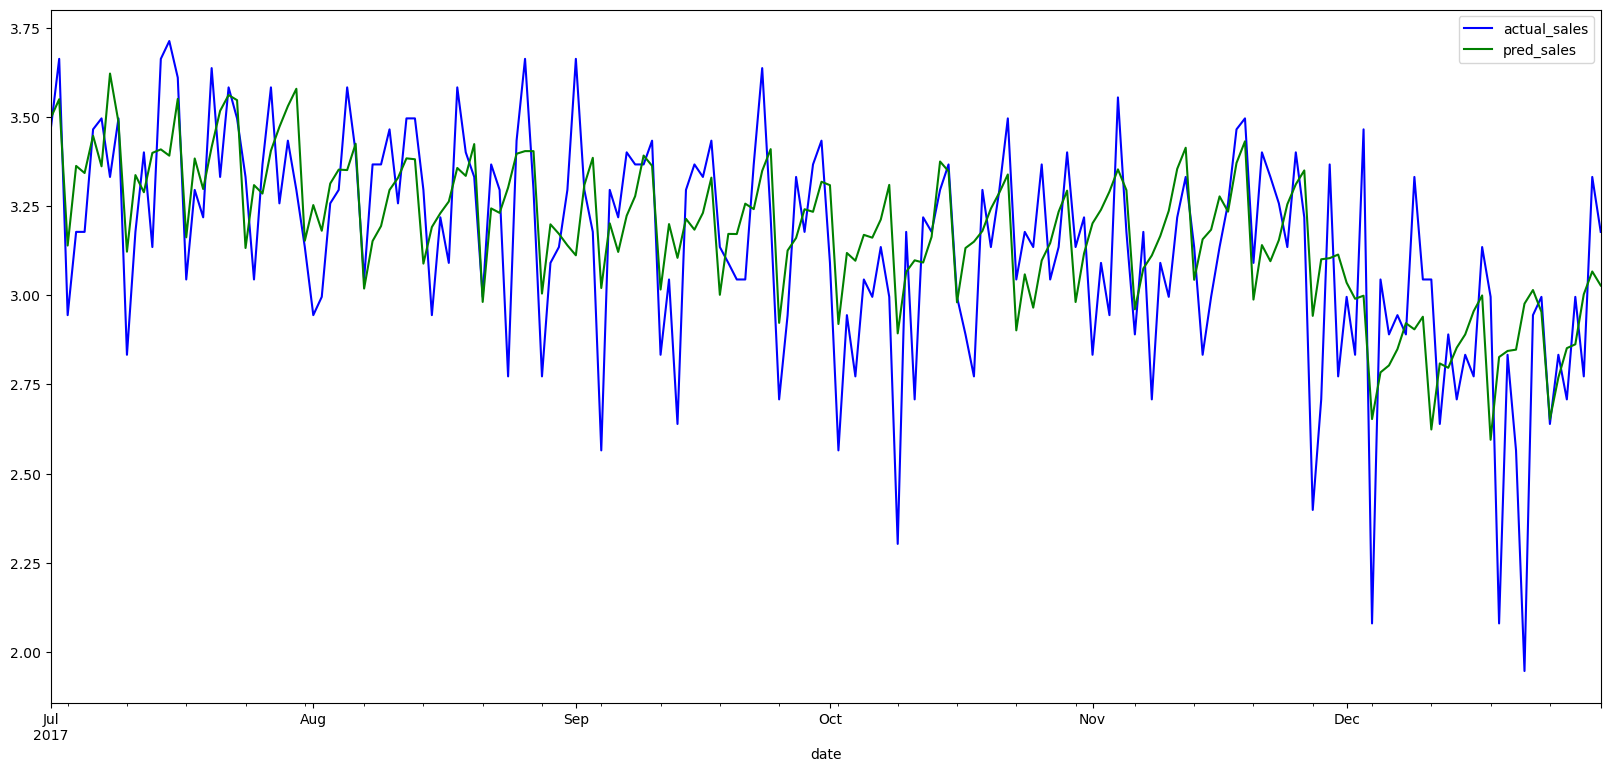

In [37]:
forecast = pd.DataFrame({
    "date": val["date"].values,
    "store": val["store"].values,
    "item": val["item"].values,
    "actual_sales": Y_val.values,
    "pred_sales": y_pred_val
})


(forecast.query("store == 1 & item == 1")
        .set_index("date")[["actual_sales", "pred_sales"]]
        .plot(figsize=(20,9), color=["blue", "green"]))


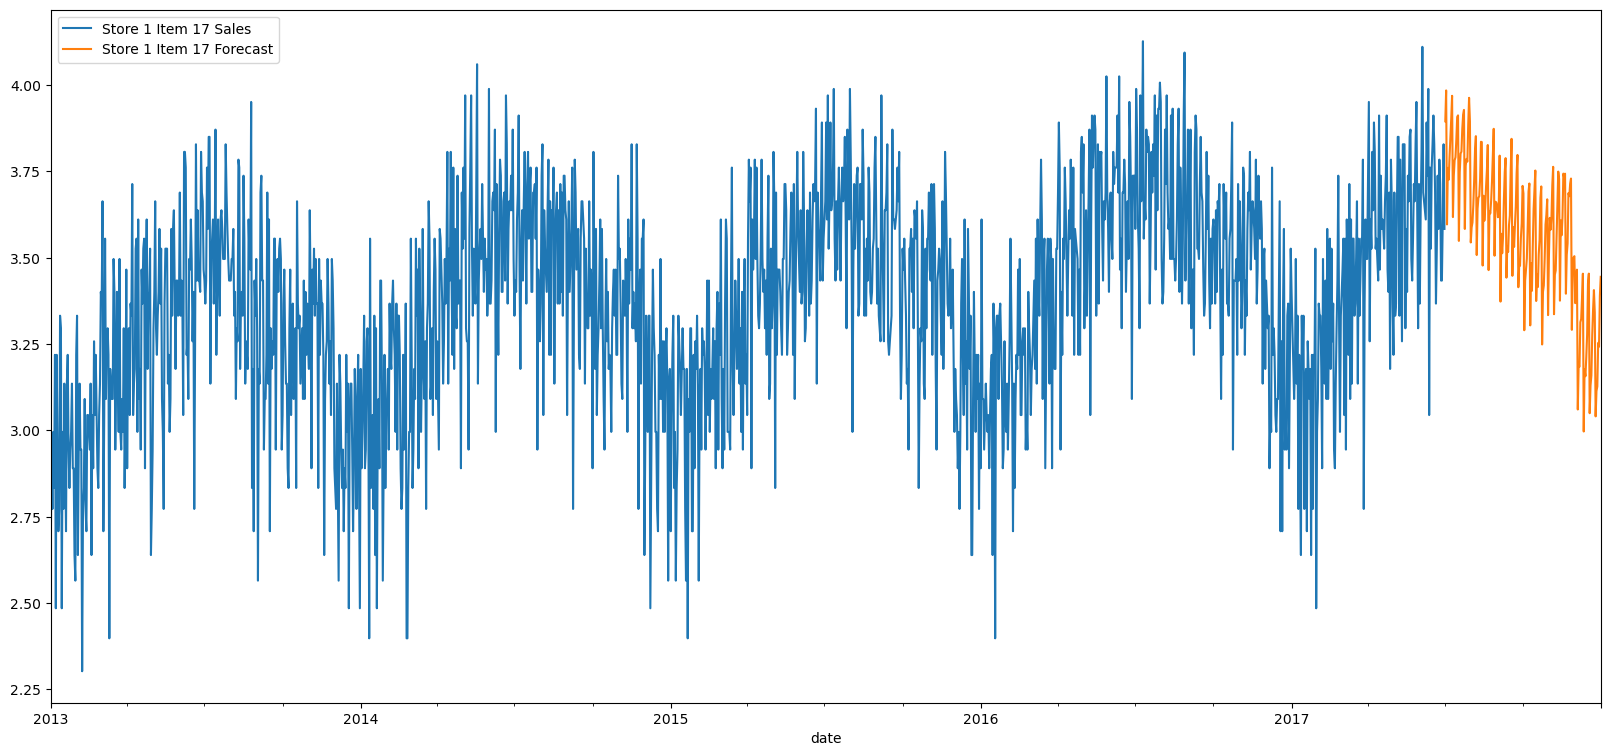

In [38]:
train[(train.store == 1) & (train.item == 17)].set_index("date").sales.plot(figsize = (20,9),legend=True, label = "Store 1 Item 17 Sales")
forecast[(forecast.store == 1) & (forecast.item == 17)].set_index("date").pred_sales.plot(legend=True, label = "Store 1 Item 17 Forecast");